## Homework 3
#### Sam Myers

In [86]:
import pandas as pd
import numpy as np
from scipy.stats import norm, hypergeom, poisson
from thinkbayes2 import Suite, Pmf, Beta, MakeBinomialPmf, MakeGammaPmf, MakePoissonPmf, Odds, MakeMixture
import thinkplot

### Flea beetle problem

Different species of flea beetle can be distinguished by the width and angle of the aedeagus. The data below includes measurements and know species classification for 74 specimens.

Suppose you discover a new specimen under conditions where it is equally likely to be any of the three species. You measure the aedeagus and width 140 microns and angle 15 (in multiples of 7.5 degrees). What is the probability that it belongs to each species?

In [87]:
df = pd.read_csv('../data/flea_beetles.csv', delimiter='\t')

widths = {name: group.Width for name, group in df.groupby('Species')}
angles = {name: group.Angle for name, group in df.groupby('Species')}

In [88]:
class FleaBeetle(Suite):
    def Likelihood(self, data, hypo):
        width, angle = data
        
        width_dist = norm(*norm.fit(widths[hypo]))
        angle_dist = norm(*norm.fit(widths[hypo]))
        
        return width_dist.pdf(width) * angle_dist.pdf(angle)

In [89]:
suite = FleaBeetle(df.Species.unique())
suite.Update((140, 15))
suite.Print()

Con 0.9999530667572274
Hei 4.6933242772619796e-05
Hep 9.773545027217173e-78


### Alien blaster problem

In preparation for an alien invasion, the Earth Defense League (EDL) has been working on new missiles to shoot down space invaders.  Of course, some missile designs are better than others; let's assume that each design has some probability of hitting an alien ship, x.

Based on previous tests, the distribution of x in the population of designs is well described by a Beta distribution with parameters 5, 10.

Now suppose the new ultra-secret Alien Blaster 9000 is being tested.  In a press conference, an EDL general reports that the new design has been tested twice, taking two shots during each test.  The results of the test are confidential, so the general won't say how many targets were hit, but they report: "The same number of targets were hit in the two tests, so we have reason to think this new design is consistent."

Is this data good or bad; that is, does it increase or decrease your estimate of x for the Alien Blaster 9000?

In [90]:
class AlienBlaster(Suite):
    def Likelihood(self, data, hypo):
        num_tests, num_shots = data

        pmf = MakeBinomialPmf(num_tests, hypo)

        return np.sum([prob ** num_tests for hits, prob in pmf.Items()])

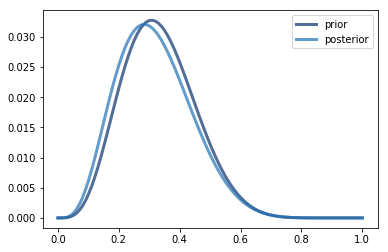

<Figure size 576x432 with 0 Axes>

In [91]:
prior = Beta(5, 10).MakePmf()
suite = AlienBlaster(prior)
suite.Update((2, 2))
thinkplot.Pdf(prior, label='prior')
thinkplot.Pdf(suite, label='posterior')
thinkplot.Show()

### Grizzly bear problem

In 1996 and 1997 Mowat and Strobeck deployed bear traps in locations in British Columbia and Alberta, in an effort to estimate the population of grizzly bears.  They describe the experiment in "Estimating Population Size of Grizzly Bears Using Hair Capture, DNA Profiling, and Mark-Recapture Analysis"

The "trap" consists of  a lure and several strands of barbed wire intended to capture samples of hair from bears that visit the lure.  Using the hair samples, the researchers use DNA analysis to identify individual bears.

During the first session, on June 29, 1996, the researchers deployed traps at 76 sites.  Returning 10 days later, they obtained 1043 hair samples and identified 23 different bears.  During a second 10-day session they obtained 1191 samples from 19 different bears, where 4 of the 19 were from bears they had identified in the first batch.

To estimate the population of bears from this data, we need a model for the probability that each bear will be observed during each session.  As a starting place, we'll make the simplest assumption, that every bear in the population has the same (unknown) probability of being sampled during each round.

We also need a prior distribution for the population.  As a starting place, let's suppose that, prior to this study, an expert in this domain would have estimated that the population is between 100 and 500, and equally likely to be any value in that range.

In [92]:
class GrizzlyBears(Suite):
    def Likelihood(self, data, hypo):
        first, second, overlap = data
        
        rv = hypergeom(hypo, first, second)
        return rv.pmf(overlap)

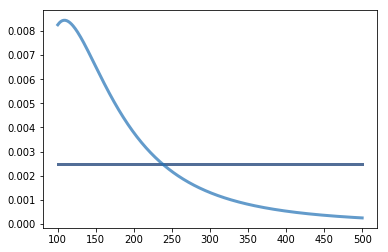

In [93]:
prior = Pmf(range(100, 501))
suite = GrizzlyBears(prior)
suite.Update((23, 19, 4))
thinkplot.Pdf(prior)
thinkplot.Pdf(suite)

### World cup problem (Part 2)

In the final match of the 2014 FIFA World Cup, Germany defeated Argentina 1-0. How much evidence does this victory provide that Germany had the better team? What is the probability that Germany would win a rematch?

In [94]:
class WorldCupTeam(Suite):
    def Likelihood(self, data, hypo):
        return poisson.pmf(data, hypo)

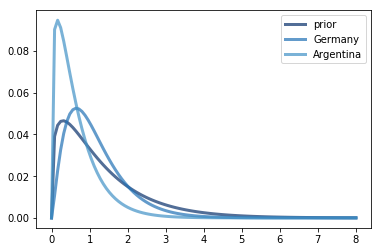

<Figure size 576x432 with 0 Axes>

In [95]:
# from examples/world_cup01
xs = np.linspace(0, 8, 101)
prior = WorldCupTeam(MakeGammaPmf(xs, 1.3))

germany = prior.Copy()
argentina = prior.Copy()
germany.Update(1)
argentina.Update(0)

thinkplot.Pdf(prior, label='prior')
thinkplot.Pdf(germany, label='Germany')
thinkplot.Pdf(argentina, label='Argentina')
thinkplot.Show()

In [96]:
prior_odds = 1
posterior_odds = Odds(germany.ProbGreater(argentina))
print('Bayes Factor:', posterior_odds / prior_odds)

Bayes Factor: 2.315582375066283


In [97]:
def get_prediction(team):
    metapmf = Pmf()

    for goal_rate, prob in team.Items():
        prediction = MakePoissonPmf(goal_rate, 8)
        metapmf[prediction] = prob

    return MakeMixture(metapmf)

germany_prediction = get_prediction(germany)
argentina_prediction = get_prediction(argentina)

win_prob = germany_prediction.ProbGreater(argentina_prediction)
lose_prob = argentina_prediction.ProbGreater(germany_prediction)

print('Germany wins rematch:', win_prob)
print('Argentina wins rematch:', lose_prob)
print('Rematch is a tie:', 1 - win_prob - lose_prob)

Germany wins rematch: 0.44769079181846805
Argentina wins rematch: 0.22518000846662528
Rematch is a tie: 0.32712919971490667


### Game of Ur problem

In the Royal Game of Ur, players advance tokens along a track with 14 spaces.  To determine how many spaces to advance, a player rolls 4 dice with 4 sides.  Two corners on each die are marked; the other two are not.  The total number of marked corners -- which is 0, 1, 2, 3, or 4 -- is the number of spaces to advance.

For example, if the total on your first roll is 2, you could advance a token to space 2.  If you roll a 3 on the next roll, you could advance the same token to space 5.

Suppose you have a token on space 13.  How many rolls did it take to get there?

Hint: you might want to start by computing the distribution of k given n, where k is the number of the space and n is the number of rolls.

Then think about the prior distribution of n.

In [98]:
class GameOfUr(Suite):
    def Likelihood(self, data, hypo):
        dice = MakeBinomialPmf(4, 0.5)
        all_dice = sum([dice] * hypo)
        return all_dice.Prob(data)

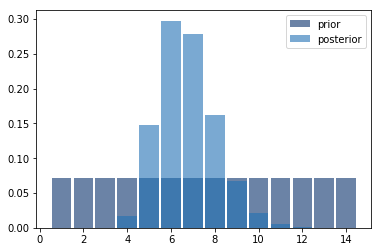

<Figure size 576x432 with 0 Axes>

In [99]:
prior = Pmf(range(1, 15))
suite = GameOfUr(prior)
suite.Update(13)
thinkplot.Hist(prior, label='prior')
thinkplot.Hist(suite, label='posterior')
thinkplot.Show()